In [142]:
import numpy as np
import torch
import torch.nn as nn
from layers import *
from utils import *
import scipy.sparse as sp
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from vis import *

In [143]:
import pickle as pkl

import networkx as nx
import numpy as np
import scipy.sparse as sp
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import sklearn.preprocessing as preprocess
import sys
def load_data(dataset_str): # {'pubmed', 'citeseer', 'cora'}
    """Load data."""

    if dataset_str == 'wiki':
        adj, features, label = load_wiki()
        return adj, features, label, 0, 0, 0

    elif dataset_str in ["cora", "citeseer", "pubmed"]:

        names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
        objects = []
        for i in range(len(names)):
            with open("/data/liuyue/New/AGE/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
                if sys.version_info > (3, 0):
                    objects.append(pkl.load(f, encoding='latin1'))
                else:
                    objects.append(pkl.load(f))

        x, y, tx, ty, allx, ally, graph = tuple(objects)
        test_idx_reorder = parse_index_file("/data/liuyue/New/AGE/data/ind.{}.test.index".format(dataset_str))
        test_idx_range = np.sort(test_idx_reorder)

        if dataset_str == 'citeseer':
            # Fix citeseer dataset (there are some isolated nodes in the graph)
            # Find isolated nodes, add them as zero-vecs into the right position
            test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
            tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
            tx_extended[test_idx_range-min(test_idx_range), :] = tx
            tx = tx_extended
            ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
            ty_extended[test_idx_range-min(test_idx_range), :] = ty
            ty = ty_extended

        features = sp.vstack((allx, tx)).tolil()
        features[test_idx_reorder, :] = features[test_idx_range, :]
        adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

        labels = np.vstack((ally, ty))
        labels[test_idx_reorder, :] = labels[test_idx_range, :]

        idx_test = test_idx_range.tolist()
        idx_train = range(len(y))
        idx_val = range(len(y), len(y)+500)


        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.view(-1)
            else:
                labels = labels.argmax(1)

    elif dataset_str in ["amazon-photo", "amazon-computers"]:
        map2names = {
            "amazon-photo": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_photo.npz",
            "amazon-computers": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_computers.npz",
        }

        data = np.load(map2names[dataset_str])
        # print(list(data.keys()))
        adj_data, adj_indices, adj_indptr, adj_shape = data["adj_data"], data["adj_indices"], data["adj_indptr"], data["adj_shape"]
        attr_data, attr_indices, attr_indptr, attr_shape = data["attr_data"], data["attr_indices"], data["attr_indptr"], data["attr_shape"]
        labels = data["labels"]

        adj = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape).tocoo()
        features = sp.csr_matrix((attr_data, attr_indices, attr_indptr), shape=attr_shape).tocoo()

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.reshape(-1)
            else:
                labels = labels.argmax(1)

        return adj, features, labels, 0, 0, 0

    return adj, features, labels, idx_train, idx_val, idx_test

def load_wiki():
    f = open('/data/liuyue/New/AGE/data/graph.txt','r')
    adj, xind, yind = [], [], []
    for line in f.readlines():
        line = line.split()
        
        xind.append(int(line[0]))
        yind.append(int(line[1]))
        adj.append([int(line[0]), int(line[1])])
    f.close()
    ##print(len(adj))

    f = open('/data/liuyue/New/AGE/data/group.txt','r')
    label = []
    for line in f.readlines():
        line = line.split()
        label.append(int(line[1]))
    f.close()

    f = open('/data/liuyue/New/AGE/data/tfidf.txt','r')
    fea_idx = []
    fea = []
    adj = np.array(adj)
    adj = np.vstack((adj, adj[:,[1,0]]))
    adj = np.unique(adj, axis=0)
    
    labelset = np.unique(label)
    labeldict = dict(zip(labelset, range(len(labelset))))
    label = np.array([labeldict[x] for x in label])
    adj = sp.csr_matrix((np.ones(len(adj)), (adj[:,0], adj[:,1])), shape=(len(label), len(label)))

    for line in f.readlines():
        line = line.split()
        fea_idx.append([int(line[0]), int(line[1])])
        fea.append(float(line[2]))
    f.close()

    fea_idx = np.array(fea_idx)
    features = sp.csr_matrix((fea, (fea_idx[:,0], fea_idx[:,1])), shape=(len(label), 4973)).toarray()
    scaler = preprocess.MinMaxScaler()
    #features = preprocess.normalize(features, norm='l2')
    features = scaler.fit_transform(features)
    features = torch.FloatTensor(features)

    return adj, features, label
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [144]:
plot_models = ["AGE", "Ours"]
plot_datasets = ["cora", "citeseer", "wiki", "pubmed"]

In [145]:
true_labels = {}
num_features = {}
num_edges = {}
sm_feas = {}
raw_adjs = {}
nclasses = {
    "cora": 7,
    "citeseer": 6,
    "pubmed": 3,
    "wiki": 19, 
}
GNN_Layers = {
    "cora": 8,
    "citeseer": 3,
    "pubmed": 1,
    "wiki": 35, 
}
from utils import *
for dataset in plot_datasets:
    adj, features, label, _, _, _ = load_data(dataset)
    true_labels[dataset] = label
    num_features[dataset] = features.shape[-1]
    num_edges[dataset] = adj.sum()
    
    adj_norm_s = preprocess_graph(adj, GNN_Layers[dataset], norm='sym', renorm=True)
    sm_fea_s = sp.csr_matrix(features).toarray()
        
    print('Laplacian Smoothing...')
    for idx, a in enumerate(adj_norm_s):
        sm_fea_s = a.dot(sm_fea_s)
    sm_feas[dataset] = sm_fea_s
    raw_adjs[dataset] = adj
    
    print("{}: {} {}".format(dataset, label.shape, features.shape[-1]))

Laplacian Smoothing...
cora: (2708,) 1433
Laplacian Smoothing...
citeseer: (3327,) 3703
Laplacian Smoothing...
wiki: (2405,) 4973
Laplacian Smoothing...
pubmed: (19717,) 500


In [133]:
def louvain_cluster(adj, labels, random_state=None):
    from community import community_louvain
    import networkx as nx
    from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI

    graph = nx.from_scipy_sparse_matrix(adj)
    partition = community_louvain.best_partition(graph, random_state=random_state)
    preds = list(partition.values())

    return preds

In [134]:
from tqdm import tqdm
import numpy as np
def sampling(adj, rate=0.5, random_state=None):
    n = adj.shape[0]
    adj = adj.toarray()
    
    ret = np.zeros((n,n))
    
    for i in range(n):
        row_idx = adj[i].nonzero()[0]
        arr = np.random.RandomState(seed=random_state).choice(row_idx, int(rate*row_idx.shape[0]))
        ret[i][arr] = 1
    
    return sp.coo_matrix(ret)

In [7]:
models = ["AGE", "Ours"]
datasets = [
    "cora",
    "citeseer",
    "wiki",
    "pubmed",
]
df = pd.DataFrame(data={"models":models}, columns=["models"] + datasets)
df

,models,cora,citeseer,wiki,pubmed
0,AGE,NaN,NaN,NaN,NaN
1,Ours,NaN,NaN,NaN,NaN


In [8]:
df_nmi = df.copy()
df_ami = df.copy()
df_ari = df.copy()
df_edges = df.copy()

In [10]:
import numpy as np
import scipy.sparse as sp
model = "AGE"
datasets = ["cora", "citeseer", "wiki", "pubmed"]
for dataset in datasets:
    nseed = 10
    edges = []
    labels = true_labels[dataset]
    for seed in range(nseed):
        print(model, dataset, seed)
        data = np.load("outputs/AGE_{}_emb_{}.npz".format(dataset, seed))
        emb = data["emb"]
        sim = np.matmul(emb, np.transpose(emb))
        sim[sim > 0.5] = 1
        sim[sim <= 0.5] = 0
        
        edges.append(sim.sum())
    df_edges["{}".format(dataset)][0] = np.mean(edges)

model = "Ours"
for dataset in datasets:
    nseed = 10
    edges = []
    labels = true_labels[dataset]
    for seed in range(nseed):
        print(model, dataset, seed)
        data = np.load("OursvsAGE/Ours/{}_{}.npz".format(dataset, seed))
        adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
        adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
        
        edges.append(adj.sum())
    df_edges["{}".format(dataset)][1] = np.mean(edges)
df_edges

AGE cora 0
AGE cora 1
AGE cora 2
AGE cora 3
AGE cora 4
AGE cora 5
AGE cora 6
AGE cora 7
AGE cora 8
AGE cora 9
AGE citeseer 0
AGE citeseer 1
AGE citeseer 2
AGE citeseer 3
AGE citeseer 4
AGE citeseer 5
AGE citeseer 6
AGE citeseer 7
AGE citeseer 8
AGE citeseer 9
AGE wiki 0
AGE wiki 1
AGE wiki 2
AGE wiki 3
AGE wiki 4
AGE wiki 5
AGE wiki 6
AGE wiki 7
AGE wiki 8
AGE wiki 9
AGE pubmed 0
AGE pubmed 1
AGE pubmed 2
AGE pubmed 3
AGE pubmed 4
AGE pubmed 5
AGE pubmed 6
AGE pubmed 7
AGE pubmed 8
AGE pubmed 9
Ours cora 0
Ours cora 1
Ours cora 2
Ours cora 3
Ours cora 4
Ours cora 5
Ours cora 6
Ours cora 7
Ours cora 8
Ours cora 9
Ours citeseer 0
Ours citeseer 1
Ours citeseer 2
Ours citeseer 3
Ours citeseer 4
Ours citeseer 5
Ours citeseer 6
Ours citeseer 7
Ours citeseer 8
Ours citeseer 9
Ours wiki 0
Ours wiki 1
Ours wiki 2
Ours wiki 3
Ours wiki 4
Ours wiki 5
Ours wiki 6
Ours wiki 7
Ours wiki 8
Ours wiki 9
Ours pubmed 0
Ours pubmed 1
Ours pubmed 2
Ours pubmed 3
Ours pubmed 4
Ours pubmed 5
Ours pubmed 6
Ou

,models,cora,citeseer,wiki,pubmed
0,AGE,1154306.625,1787913.25,1355359.375,189111120.0
1,Ours,1139760.9,520826.6,403115.0,91307808.7


AGE cora
{10556: 0.4628243064459773, 21112: 0.4819186311686866, 31668: 0.4932528563421804, 42224: 0.4905650020515272, 52780: 0.49241947318511636, 63336: 0.49086688362927966, 73892: 0.4940116246424311, 84448: 0.4920068151537496, 95004: 0.49546175630429834, 105560: 0.4961842233083183}
AGE citeseer
{9228: 0.3283198164920913, 18456: 0.43868252110074807, 27684: 0.4355607881177477, 36912: 0.4483194245060271, 46140: 0.4484018322980923, 55368: 0.44876356687764957, 64596: 0.4471968098056848, 73824: 0.4465165672365042, 83052: 0.4455258134138346, 92280: 0.44771453664123523}
AGE wiki
{24357: 0.23690768122036734, 48714: 0.2435905621039589, 73071: 0.26375140063188174, 97428: 0.26134183648262627, 121785: 0.2508727694624637, 146142: 0.24912336861681786, 170499: 0.24930966212868091, 194856: 0.2446559928985928, 219213: 0.2501815344270851, 243570: 0.25192650437493436}
AGE pubmed
{88651: 0.049398971094412526, 177302: 0.10971718786098791, 265953: 0.1317347701426905, 354604: 0.1526639796996361, 443255: 0.15

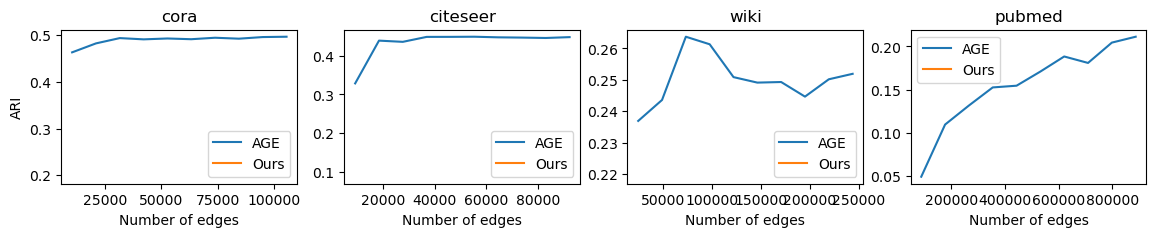

In [153]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI
from vis import *
import numpy as np
import random
import matplotlib.pyplot as plt

plot_datasets = ["cora", "citeseer", "wiki", "pubmed"]
fig, axs = plt.subplots(1, len(plot_datasets), figsize=(14,2))

for model_idx, model in enumerate(plot_models):
    for dataset_idx, dataset in enumerate(plot_datasets):
        nseed = 10
        print(model, dataset)
        
        nmi_m, ami_m, ari_m = {}, {}, {}
            
#         edges = np.arange(num_edges[dataset], 201*num_edges[dataset], 10*num_edges[dataset], dtype=int)
        edges = np.arange(num_edges[dataset], 11*num_edges[dataset], num_edges[dataset], dtype=int)
        for m in edges: 
            nmis, amis, aris = [], [], []
            for seed in np.arange(nseed):
                np.random.seed(seed)
                random.seed(seed)
                
                try:
                    data = np.load("Cluster/{}/lo_{}_preds_{}_{}.npz".format(model, dataset, seed, m))
                    preds = data["preds"]
                    labels = true_labels[dataset]
                    
                    nmi = NMI(labels, preds)
                    ami = AMI(labels, preds)
                    ari = ARI(labels, preds)
   
                    nmis.append(nmi)
                    amis.append(ami)
                    aris.append(ari)

                except Exception as e:
                    pass
#                     print(e)
                    
            if len(nmis) > 0:
                nmi_m[m] = np.mean(nmis)
                ami_m[m] = np.mean(amis)
                ari_m[m] = np.mean(aris)
            
        print(ari_m)
        
        ax = axs[dataset_idx]
        ax.plot(ari_m.keys(), ari_m.values(), label=model)
        ax.title.set_text("{}".format(dataset))
        ax.set_xlabel("Number of edges")
        if dataset_idx == 0:
            ax.set_ylabel("ARI")
        
        ax.legend()
        
        
            

In [31]:
nodes = {
    "cora": 2708,
    "citeseer": 3327,
    "wiki": 2405,
    "pubmed": 19717,
}

In [36]:
for dataset in plot_datasets:
    edges = np.arange(num_edges[dataset], df_edges[dataset][0], 10*num_edges[dataset])
    print(edges.shape)

(11,)
(19,)
(6,)
(214,)


In [35]:
200 * 19717

3943400

In [5]:
class BinaryClassification(nn.Module):
    def __init__(self, in_dim, hidden_dim, dropout=0.1):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(in_dim, hidden_dim) 
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_out = nn.Linear(hidden_dim, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim)

    #     self.init_weights()

    # def init_weights(self):
    #     nn.init.xavier_normal_(self.layer_1.weight, gain=1.414)
    #     nn.init.xavier_normal_(self.layer_2.weight, gain=1.414)
    #     nn.init.xavier_normal_(self.layer_out.weight, gain=1.414)

    #     # nn.init.xavier_normal_(self.batchnorm1.weight, gain=1.414)
    #     # nn.init.xavier_normal_(self.batchnorm2.weight, gain=1.414)
    
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x.reshape(-1)


cora 0


100%|███████████████████████████████████████████████████████████████████| 2708/2708 [00:09<00:00, 272.66it/s]


372988 34491.0


100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.29it/s]


0.47377643896801624 0.4086451810155947 0.33734178411344606
citeseer 0


100%|███████████████████████████████████████████████████████████████████| 3327/3327 [00:13<00:00, 237.74it/s]


92785 7599.0


100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.00it/s]


0.3586506310446746 0.1523728487101729 0.12252209163310807
wiki 0


100%|███████████████████████████████████████████████████████████████████| 2405/2405 [00:11<00:00, 205.93it/s]


62399 5039.0


100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.50it/s]


0.5168038371401608 0.3428199099747981 0.2163085868523718


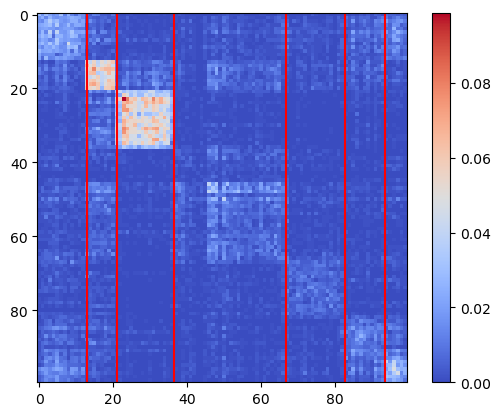

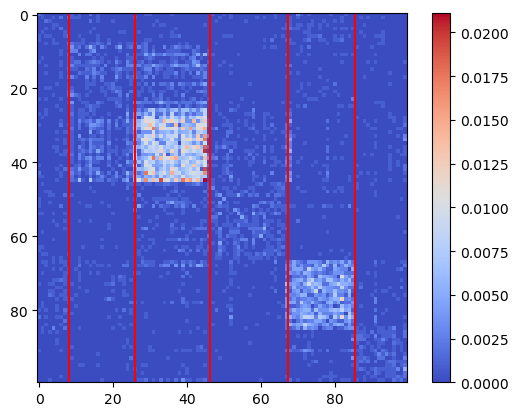

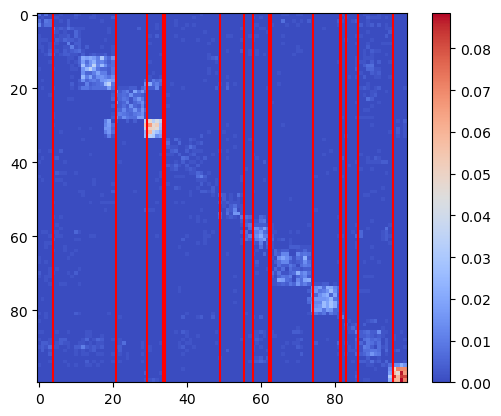

In [29]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI
from vis import *

plot_datasets = ["cora", "citeseer", "wiki"]

model="Ours"
for dataset in plot_datasets:
    nseed = 1
    for seed in range(nseed):
        print(dataset, seed)
        
        np.random.seed(seed)
        random.seed(seed)
        
        labels = true_labels[dataset]
        
        model_path = "saved_models_/Oursv-{}-{}.statedict".format(dataset, seed)
        model = BinaryClassification(num_features[dataset], 256)
        model.load_state_dict(torch.load(model_path))
        model = model.cuda()
        
        model.eval()
        row, col, data = [], [], []
        arr = np.arange(labels.shape[0], dtype=int)
        M_edges = labels.shape[0]
        sims = np.zeros((labels.shape[0], labels.shape[0]))
        with torch.no_grad():
            inx = torch.FloatTensor(embs[dataset]).cuda()
            
            for i in tqdm(range(inx.shape[0])):
                inputs = (inx[i] * inx).cuda()
                inputs = F.normalize(inputs)
                preds = torch.sigmoid(model(inputs))
                
                neib_ids = arr[preds.cpu() > 0.5]
                if neib_ids.shape[0] > M_edges:
                    neib_ids = np.random.permutation(neib_ids)
                    neib_ids = neib_ids[:M_edges]

                # data += (preds.cpu().tolist())
                # row += ([i] * emb.shape[0])
                # col += ([x for x in range(emb.shape[0])])

                data += [1] * neib_ids.shape[0]
                row += [i] * neib_ids.shape[0]
                col += neib_ids.tolist()
                
                sims[i] = preds.cpu().numpy()
                
            adj = sp.coo_matrix((data, (row, col)), shape=(labels.shape[0], labels.shape[0]))
            adj.eliminate_zeros()
            
            adj_s = sampling(adj, rate=0.1)
#             adj_s = adj
            
            print("{} {}".format(adj.sum(), adj_s.sum()))
            
            plot_superadj(adj_s, K=100, sparse=True, labels=labels, dataset="link_s_{}".format(dataset), vline=True)
            
            
#             cluster = SpectralClustering(n_clusters=nclasses[dataset], affinity="precomputed", random_state=seed)
#             preds = cluster.fit_predict(sims)
            preds = louvain_cluster(adj_s, labels, random_state=seed)
            labels = true_labels[dataset]
            
            nmi = NMI(labels, preds)
            ami = AMI(labels, preds)
            ari = ARI(labels, preds)
            
            print(nmi, ami, ari)
            
            

## Ours

In [154]:
datasets = ["cora", "citeseer", "wiki", "pubmed"]

In [156]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

for dataset in datasets:
    nseeds = 10
    
    nmi_m, ami_m, ari_m, nclass_m = {}, {}, {}, {}
    sampling_rates = np.arange(1.0, 11.0, 1.0)
    for sampling_rate in sampling_rates:
        nmis, amis, aris, nclasses = [], [], [], []
        for seed in range(nseeds):
            filename = "OursvsAGE/Cluster/Ours/lo_{}_preds_{}_{:.1f}.npz".format(dataset, seed, sampling_rate)
            data = np.load(filename)
            
            preds = data["preds"]
            labels = true_labels[dataset]
            
            nmi = NMI(labels, preds)
            ami = AMI(labels, preds)
            ari = ARI(labels, preds)
            nclass = np.unique(preds).shape[0]
            
            nmis.append(nmi)
            amis.append(ami)
            aris.append(ari)
            nclasses.append(nclass)
        nmi_m[sampling_rate] = np.mean(nmis)
        ami_m[sampling_rate] = np.mean(amis)
        ari_m[sampling_rate] = np.mean(aris)
        nclass_m[sampling_rate] = np.mean(nclasses)
        
    print(dataset, nclass_m.values())

cora dict_values([354.3, 227.5, 187.0, 165.8, 153.2, 136.7, 131.6, 125.0, 117.4, 117.5])
citeseer dict_values([33.8, 9.4, 6.5, 5.4, 5.0, 5.0, 5.0, 5.2, 5.0, 5.2])
wiki dict_values([397.4, 265.8, 218.3, 167.7, 154.1, 150.7, 128.9, 128.9, 128.9, 128.9])
pubmed dict_values([2171.8, 1647.1, 1389.0, 1231.3, 1100.7, 1003.8, 937.7, 887.5, 834.5, 791.0])


## Validation scores for clustering

In [87]:
lrs = [1e-3, 1e-4, 1e-5]
epochs = np.arange(100,1100,100, dtype=int)
scalers = ["minmax", "standard"]
mlp_layers = [2,3]

In [116]:
from sklearn.metrics import adjusted_rand_score as ARI, davies_bouldin_score as DBI, silhouette_score as SI
import networkx as nx
import networkx.algorithms.community as nx_comm

dataset = "wiki"
seed = 0
dropout = 0.1
m = num_edges[dataset]
edges = np.arange(10*m, 11*m, m, dtype=int)
df_data = pd.DataFrame(columns=["Dataset", "Params", "ARI", "DBI", "SI", "NUM_CLUSTERS", "MOD"])
for lr in lrs:
    for epoch in epochs:
        for scaler in scalers:
            for mlp_layer in mlp_layers:
                for sampling_edges in edges:
                    params = "{}_{}_{}_{:.1f}_{}_{}_{}_{:.1f}".format(dataset, seed, lr, dropout, epoch, scaler, mlp_layer, sampling_edges / m)
                    print(params)
                    
                    try:
                        filename = "OursvsAGE/gs_preds/{}.npz".format(params)
                        data = np.load(filename)
                        preds = data["preds"]
                        labels = true_labels[dataset]
                        n = labels.shape[0]
#                         raw_emb = sm_feas[dataset]
#                         raw_emb = np.load("/data/liuyue/New/SBM/mySBM/emb_models/AGE/outputs/AGE_{}_emb_{}.npz".format(dataset, seed))["emb"]
#                         data = np.load("OursvsAGE/gs/{}_{}_{}_{:.1f}_{}_{}_{}.npz".format(dataset, seed, lr, dropout, epoch, scaler, mlp_layers))
#                         adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
#                         adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))
#                         graph = nx.from_scipy_sparse_matrix(adj)

                        adj = raw_adjs[dataset]
                        graph = nx.from_scipy_sparse_matrix(adj)
        
                        pp = []
                        nn = np.arange(n, dtype=int)
                        for i in np.unique(preds):
                            pp.append(nn[preds==i])
                        


                        ari = ARI(labels, preds)
                        dbi = -DBI(raw_emb, preds)
                        si = SI(raw_emb, preds)
                        num_clusters = np.unique(preds).shape[0]
                        mod = nx_comm.modularity(graph, pp)

                        new_line = pd.DataFrame([[dataset, params, ari, dbi, si, num_clusters, mod]], columns=df_data.columns)
                        df_data = pd.concat([df_data, new_line], axis=0)
                    except Exception as e:
                        print(e)
                        pass

wiki_0_0.001_0.1_100_minmax_2_10.0
wiki_0_0.001_0.1_100_minmax_3_10.0
wiki_0_0.001_0.1_100_standard_2_10.0
wiki_0_0.001_0.1_100_standard_3_10.0
wiki_0_0.001_0.1_200_minmax_2_10.0
wiki_0_0.001_0.1_200_minmax_3_10.0
wiki_0_0.001_0.1_200_standard_2_10.0
wiki_0_0.001_0.1_200_standard_3_10.0
wiki_0_0.001_0.1_300_minmax_2_10.0
wiki_0_0.001_0.1_300_minmax_3_10.0
wiki_0_0.001_0.1_300_standard_2_10.0
wiki_0_0.001_0.1_300_standard_3_10.0
wiki_0_0.001_0.1_400_minmax_2_10.0
wiki_0_0.001_0.1_400_minmax_3_10.0
wiki_0_0.001_0.1_400_standard_2_10.0
wiki_0_0.001_0.1_400_standard_3_10.0
wiki_0_0.001_0.1_500_minmax_2_10.0
wiki_0_0.001_0.1_500_minmax_3_10.0
wiki_0_0.001_0.1_500_standard_2_10.0
wiki_0_0.001_0.1_500_standard_3_10.0
wiki_0_0.001_0.1_600_minmax_2_10.0
wiki_0_0.001_0.1_600_minmax_3_10.0
wiki_0_0.001_0.1_600_standard_2_10.0
wiki_0_0.001_0.1_600_standard_3_10.0
wiki_0_0.001_0.1_700_minmax_2_10.0
wiki_0_0.001_0.1_700_minmax_3_10.0
wiki_0_0.001_0.1_700_standard_2_10.0
wiki_0_0.001_0.1_700_standard

In [117]:
df_data.to_csv("sta_gs_result.csv", index=False)

In [103]:
X = [[1,1], [2,2], [2,2.1]]

In [108]:
dbi = -DBI(X, [0,0,0])
dbi

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

{0, 1, 2}

In [137]:
from sklearn.metrics import adjusted_rand_score as ARI, davies_bouldin_score as DBI, silhouette_score as SI, adjusted_mutual_info_score as AMI, normalized_mutual_info_score as NMI
import networkx as nx
import networkx.algorithms.community as nx_comm

datasets = ["cora", "citeseer", "wiki", "pubmed"]
df_data = pd.DataFrame(columns=["Dataset", "Params", "ARI", "DBI", "SI", "NUM_CLUSTERS", "MOD", "AMI", "NMI"])
for dataset in datasets:
    seed = 0
    dropout = 0.1
    m = num_edges[dataset]
    edges = np.arange(10*m, 11*m, m, dtype=int)
#     df_data = pd.DataFrame(columns=["Dataset", "Params", "ARI", "DBI", "SI", "NUM_CLUSTERS", "MOD"])
    adj = raw_adjs[dataset]
    graph = nx.from_scipy_sparse_matrix(adj)
    for lr in lrs:
        for epoch in epochs:
            for scaler in scalers:
                for mlp_layer in mlp_layers:
                    for sampling_edges in edges:
                        params = "{}_{}_{}_{:.1f}_{}_{}_{}_{:.1f}".format(dataset, seed, lr, dropout, epoch, scaler, mlp_layer, sampling_edges / m)
                        print(params)

                        try:
                            filename = "OursvsAGE/gs_preds/{}.npz".format(params)
                            data = np.load(filename)
                            preds = data["preds"]
                            labels = true_labels[dataset]
                            
                            n = labels.shape[0]
    #                         raw_emb = sm_feas[dataset]
    #                         raw_emb = np.load("/data/liuyue/New/SBM/mySBM/emb_models/AGE/outputs/AGE_{}_emb_{}.npz".format(dataset, seed))["emb"]
#                             data = np.load("OursvsAGE/gs/{}_{}_{}_{:.1f}_{}_{}_{}.npz".format(dataset, seed, lr, dropout, epoch, scaler, mlp_layer))
#                             adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
#                             adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))
#                             adj_s = sampling(adj, rate=sampling_edges/adj.sum(), random_state=seed)
#                             graph = nx.from_scipy_sparse_matrix(adj_s)

#                             adj = raw_adjs[dataset]
#                             graph = nx.from_scipy_sparse_matrix(adj)


                            pp = []
                            nn = np.arange(n, dtype=int)
                            for i in np.unique(preds):
                                pp.append(nn[preds==i])



                            ari = ARI(labels, preds)
                            dbi = -DBI(adj.toarray(), preds)
                            si = SI(adj.toarray(), preds)
                            num_clusters = np.unique(preds).shape[0]
                            mod = nx_comm.modularity(graph, pp)
                            ami = AMI(labels, preds)
                            nmi = NMI(labels, preds)

                            new_line = pd.DataFrame([[dataset, params, ari, dbi, si, num_clusters, mod, ami, nmi]], columns=df_data.columns)
                            df_data = pd.concat([df_data, new_line], axis=0)
                        except Exception as e:
                            print(e)
                            pass

cora_0_0.001_0.1_100_minmax_2_10.0
cora_0_0.001_0.1_100_minmax_3_10.0
cora_0_0.001_0.1_100_standard_2_10.0
cora_0_0.001_0.1_100_standard_3_10.0
cora_0_0.001_0.1_200_minmax_2_10.0
cora_0_0.001_0.1_200_minmax_3_10.0
cora_0_0.001_0.1_200_standard_2_10.0
cora_0_0.001_0.1_200_standard_3_10.0
cora_0_0.001_0.1_300_minmax_2_10.0
cora_0_0.001_0.1_300_minmax_3_10.0
cora_0_0.001_0.1_300_standard_2_10.0
cora_0_0.001_0.1_300_standard_3_10.0
cora_0_0.001_0.1_400_minmax_2_10.0
cora_0_0.001_0.1_400_minmax_3_10.0
cora_0_0.001_0.1_400_standard_2_10.0
cora_0_0.001_0.1_400_standard_3_10.0
cora_0_0.001_0.1_500_minmax_2_10.0
cora_0_0.001_0.1_500_minmax_3_10.0
cora_0_0.001_0.1_500_standard_2_10.0
cora_0_0.001_0.1_500_standard_3_10.0
cora_0_0.001_0.1_600_minmax_2_10.0
cora_0_0.001_0.1_600_minmax_3_10.0
cora_0_0.001_0.1_600_standard_2_10.0
cora_0_0.001_0.1_600_standard_3_10.0
cora_0_0.001_0.1_700_minmax_2_10.0
cora_0_0.001_0.1_700_minmax_3_10.0
cora_0_0.001_0.1_700_standard_2_10.0
cora_0_0.001_0.1_700_standard

citeseer_0_1e-05_0.1_400_standard_3_10.0
citeseer_0_1e-05_0.1_500_minmax_2_10.0
citeseer_0_1e-05_0.1_500_minmax_3_10.0
citeseer_0_1e-05_0.1_500_standard_2_10.0
citeseer_0_1e-05_0.1_500_standard_3_10.0
citeseer_0_1e-05_0.1_600_minmax_2_10.0
citeseer_0_1e-05_0.1_600_minmax_3_10.0
citeseer_0_1e-05_0.1_600_standard_2_10.0
citeseer_0_1e-05_0.1_600_standard_3_10.0
citeseer_0_1e-05_0.1_700_minmax_2_10.0
citeseer_0_1e-05_0.1_700_minmax_3_10.0
citeseer_0_1e-05_0.1_700_standard_2_10.0
citeseer_0_1e-05_0.1_700_standard_3_10.0
citeseer_0_1e-05_0.1_800_minmax_2_10.0
citeseer_0_1e-05_0.1_800_minmax_3_10.0
citeseer_0_1e-05_0.1_800_standard_2_10.0
citeseer_0_1e-05_0.1_800_standard_3_10.0
citeseer_0_1e-05_0.1_900_minmax_2_10.0
citeseer_0_1e-05_0.1_900_minmax_3_10.0
citeseer_0_1e-05_0.1_900_standard_2_10.0
citeseer_0_1e-05_0.1_900_standard_3_10.0
citeseer_0_1e-05_0.1_1000_minmax_2_10.0
citeseer_0_1e-05_0.1_1000_minmax_3_10.0
citeseer_0_1e-05_0.1_1000_standard_2_10.0
citeseer_0_1e-05_0.1_1000_standard_3_

pubmed_0_0.0001_0.1_100_minmax_3_10.0
pubmed_0_0.0001_0.1_100_standard_2_10.0
pubmed_0_0.0001_0.1_100_standard_3_10.0
pubmed_0_0.0001_0.1_200_minmax_2_10.0
[Errno 2] No such file or directory: 'OursvsAGE/gs_preds/pubmed_0_0.0001_0.1_200_minmax_2_10.0.npz'
pubmed_0_0.0001_0.1_200_minmax_3_10.0
[Errno 2] No such file or directory: 'OursvsAGE/gs_preds/pubmed_0_0.0001_0.1_200_minmax_3_10.0.npz'
pubmed_0_0.0001_0.1_200_standard_2_10.0
[Errno 2] No such file or directory: 'OursvsAGE/gs_preds/pubmed_0_0.0001_0.1_200_standard_2_10.0.npz'
pubmed_0_0.0001_0.1_200_standard_3_10.0
[Errno 2] No such file or directory: 'OursvsAGE/gs_preds/pubmed_0_0.0001_0.1_200_standard_3_10.0.npz'
pubmed_0_0.0001_0.1_300_minmax_2_10.0
[Errno 2] No such file or directory: 'OursvsAGE/gs_preds/pubmed_0_0.0001_0.1_300_minmax_2_10.0.npz'
pubmed_0_0.0001_0.1_300_minmax_3_10.0
[Errno 2] No such file or directory: 'OursvsAGE/gs_preds/pubmed_0_0.0001_0.1_300_minmax_3_10.0.npz'
pubmed_0_0.0001_0.1_300_standard_2_10.0
[Errno

In [138]:
df_data.to_csv("sta_gs_result.csv", index=False)

In [139]:
adj = raw_adjs["cora"]

In [140]:
adj.nonzero()

(array([   0,    0,    0, ..., 2707, 2707, 2707], dtype=int32),
 array([ 633, 1862, 2582, ...,  598, 1473, 2706], dtype=int32))